# Setting up our Notebook

In [89]:
# Things to import

# Standard data, plotting, and mathematical tools
import numpy as np
import pandas as pd
import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime

# SARIMAX Modeling
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

# For serialization:
import joblib
import pickle

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Importing the Data

In [68]:
# Importing the data

coins=['BTC', 'ETH', 'ADA']

# Getting the PCA files
pca_files=['PCA 24 Hourly BTC.csv', 'PCA 24 Hourly ETH.csv', 'PCA 24 Hourly ADA.csv']

# Creating data frames for them
pca_BTC=pd.read_csv(pca_files[0])
y_BTC=pca_BTC['Percent Change']
pca_BTC=pca_BTC.drop('Unnamed: 0', axis=1)
del pca_BTC['Label']
del pca_BTC['Percent Change']

pca_ETH=pd.read_csv(pca_files[1])
y_ETH=pca_ETH['Percent Change']
pca_ETH=pca_ETH.drop('Unnamed: 0', axis=1)
del pca_ETH['Label']
del pca_ETH['Percent Change']

pca_ADA=pd.read_csv(pca_files[2])
y_ADA=pca_ADA['Percent Change']
pca_ADA=pca_ADA.drop('Unnamed: 0', axis=1)
del pca_ADA['Label']
del pca_ADA['Percent Change']

dfs=[y_BTC, y_ETH, y_ADA]

For SARIMAX modeling, we will not be attempting to classify something as a Buy/Hold/Sell signal, but to forecast the next time-step's change in price. From that, we can derive a trade signal using the same criteria used to create the categorical labels used in the other architectures.

# Autocorrelation Visualization

We will run autocorrelation to see if an ARIMA/SARIMA/SARIMAX model is appropriate for this data.

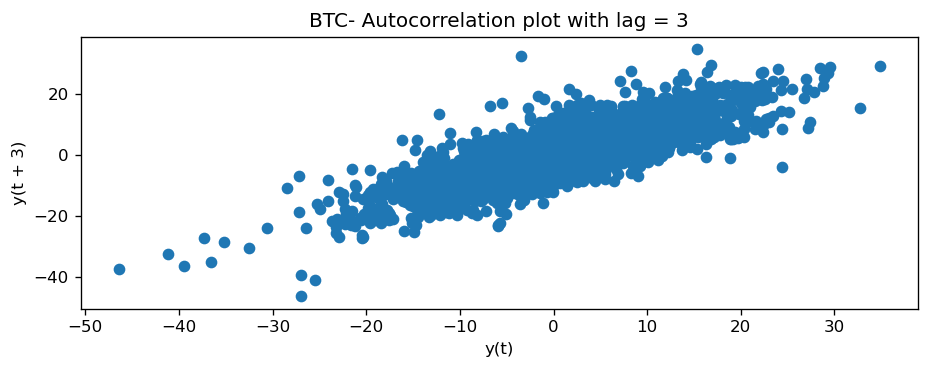

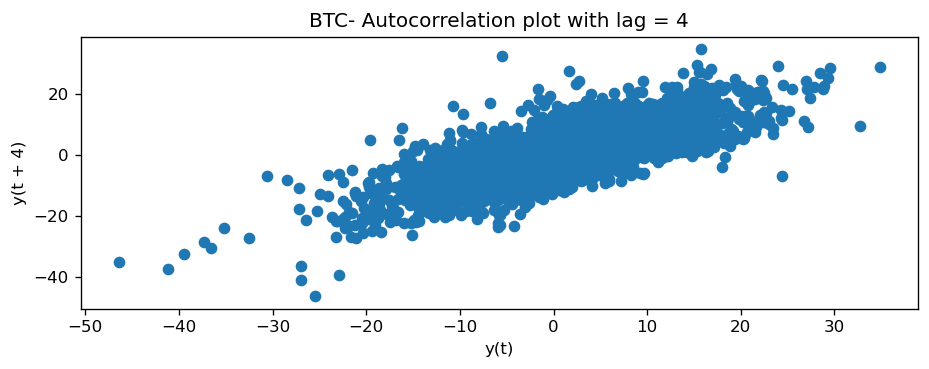

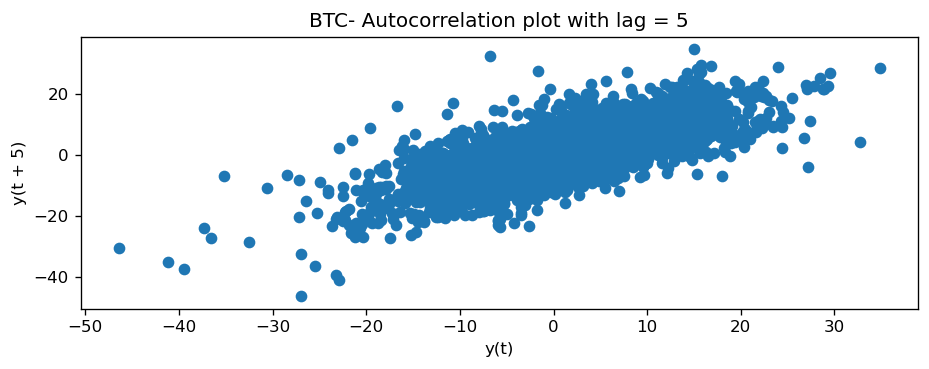

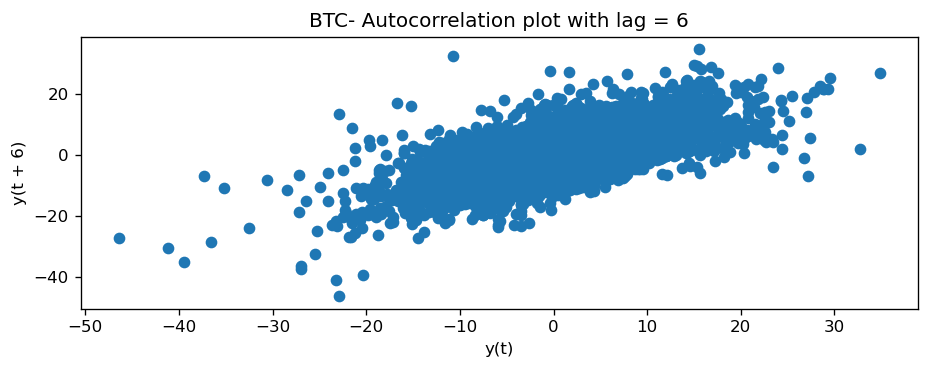

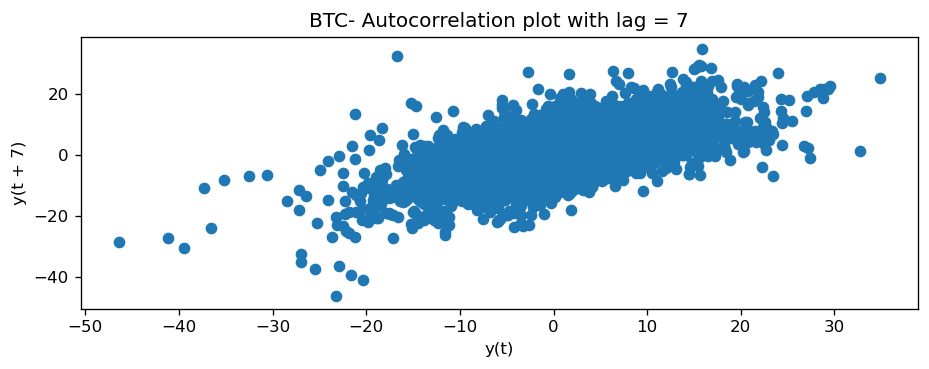

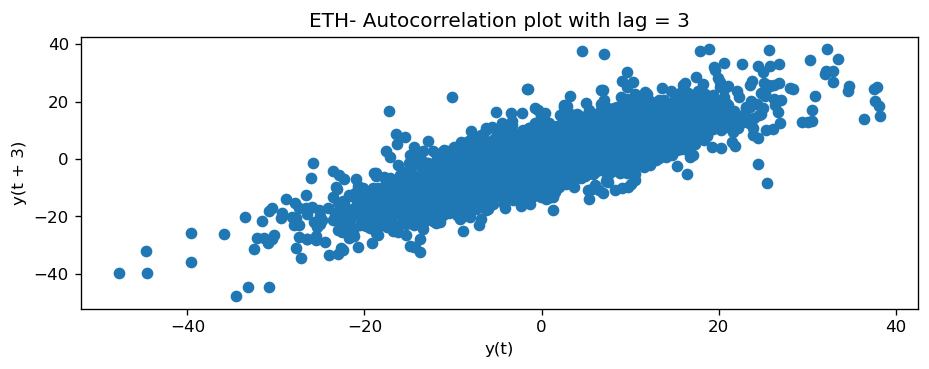

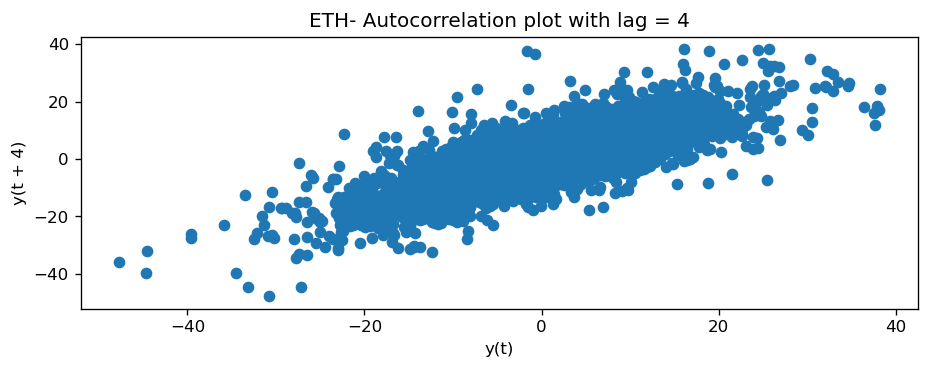

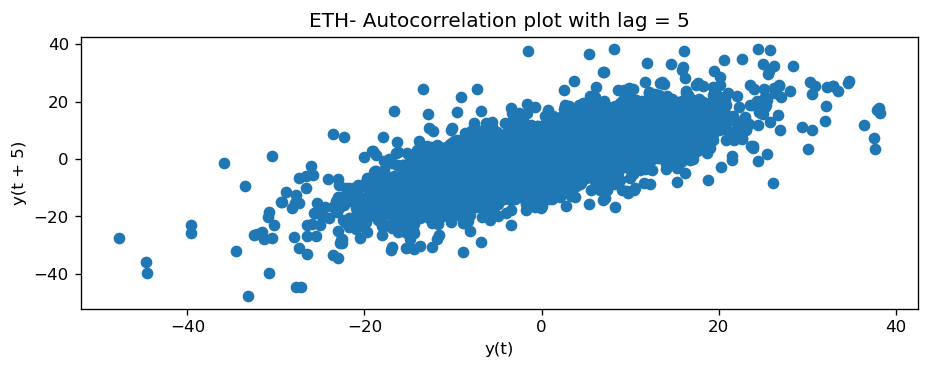

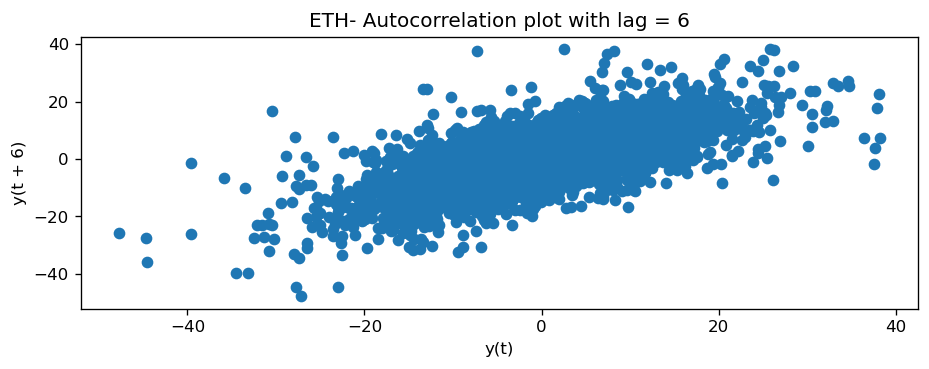

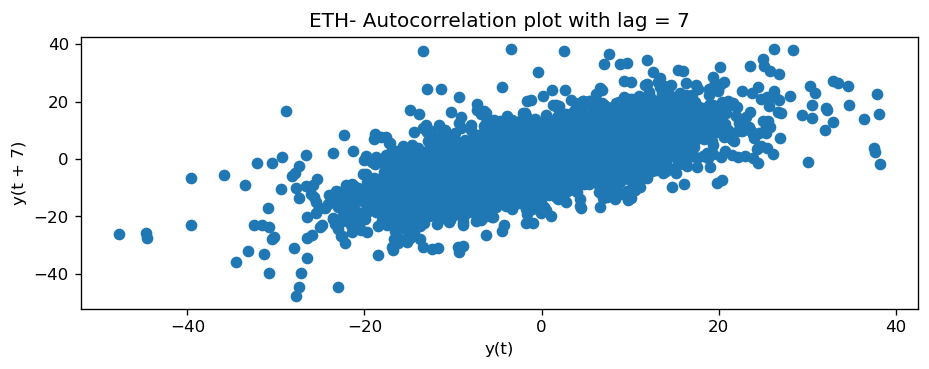

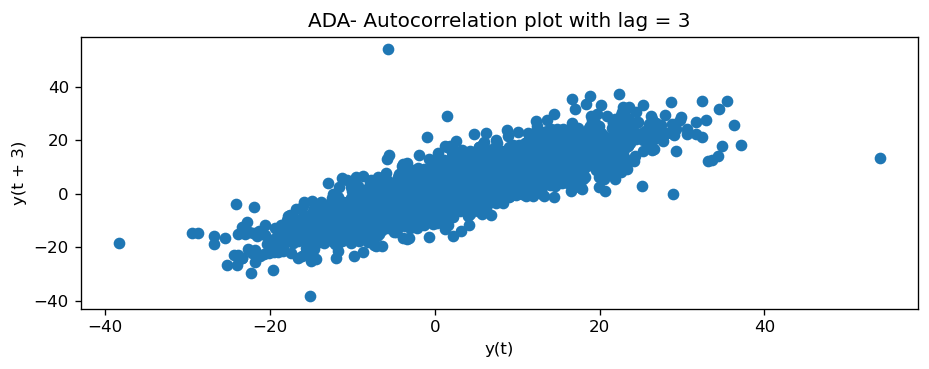

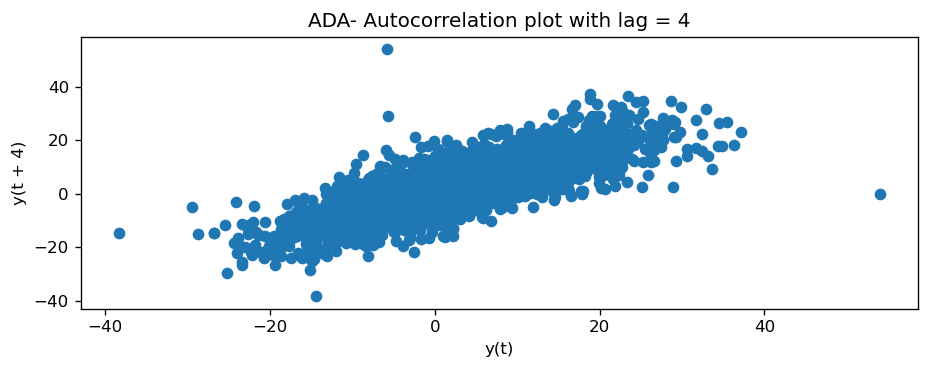

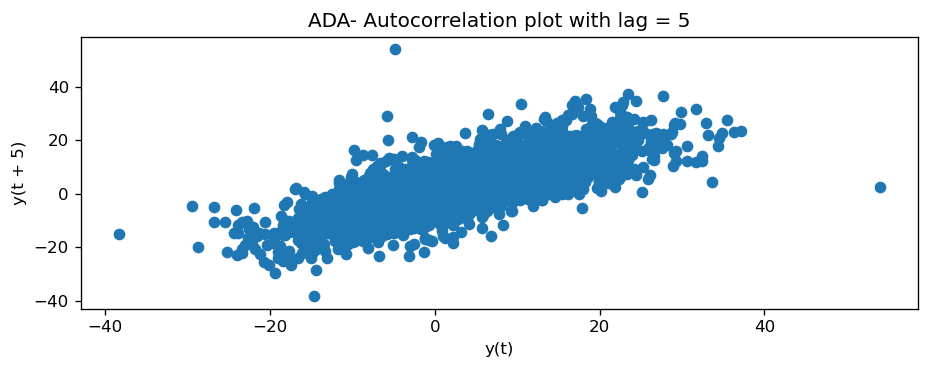

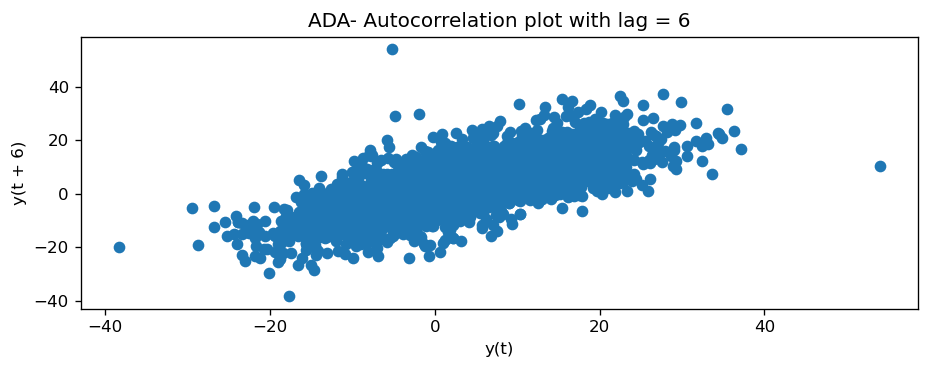

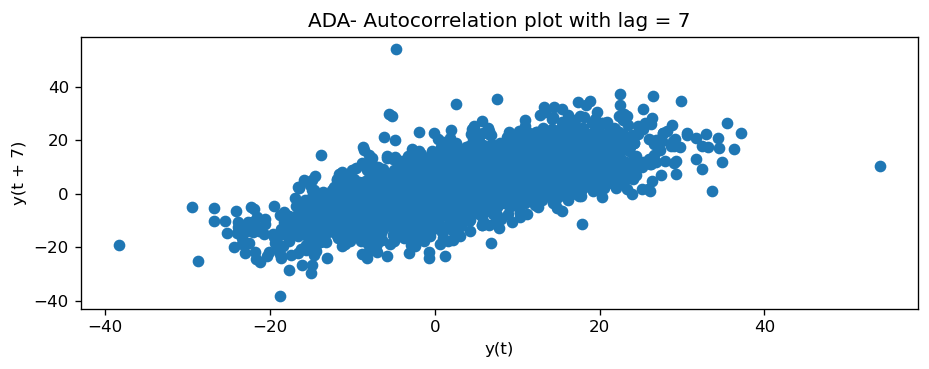

In [69]:
# Autocorrelation Visualization

for i in range(len(dfs)):
    for n in range(3,8):
        plt.figure()
        lag_plot(dfs[i], lag=n)
        plt.title(coins[i] +'- Autocorrelation plot with lag = '+str(n))
        plt.show()

Results of Autocorrelation Visualization:
    
We can clearly see autocorrelation in all time frames and for all three coins, though, as to be expected, as the lag increases, the strength of the autocorrelation decreases. Of the three, Cardano (ADA) appears to be the least autocorrelated.

# SARIMAX Modeling for BTC

Note: This section strongly follows the following guide https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ and https://towardsai.net/p/machine-learning/stock-price-change-forecasting-with-time-series-sarimax

## Manually setting up a model

### Parameters of the ARIMA model

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

### Differencing to Determine d

To begin, we need to determine whether or not to difference the data to make it more stationary. This will give us our parameter '"d".

We will use the Augmented Dickey Fuller Test to see if d should be anything other than 1.

In [70]:
for i in range(len(dfs)):
    result = adfuller(dfs[i])
    print('ADF Statistic for '+coins[i]+ ' is '+str(result[0]))
    print('p-value:for '+coins[i]+' is ' +str(result[1]))
    print('\n')

ADF Statistic for BTC is -20.83113366597517
p-value:for BTC is 0.0


ADF Statistic for ETH is -20.290583463541505
p-value:for ETH is 0.0


ADF Statistic for ADA is -12.961496647902889
p-value:for ADA is 3.2181989447146342e-24




From our results we can see the because the p-value is greater than the ADF Statistic for all three coins, that d should be different from 1.

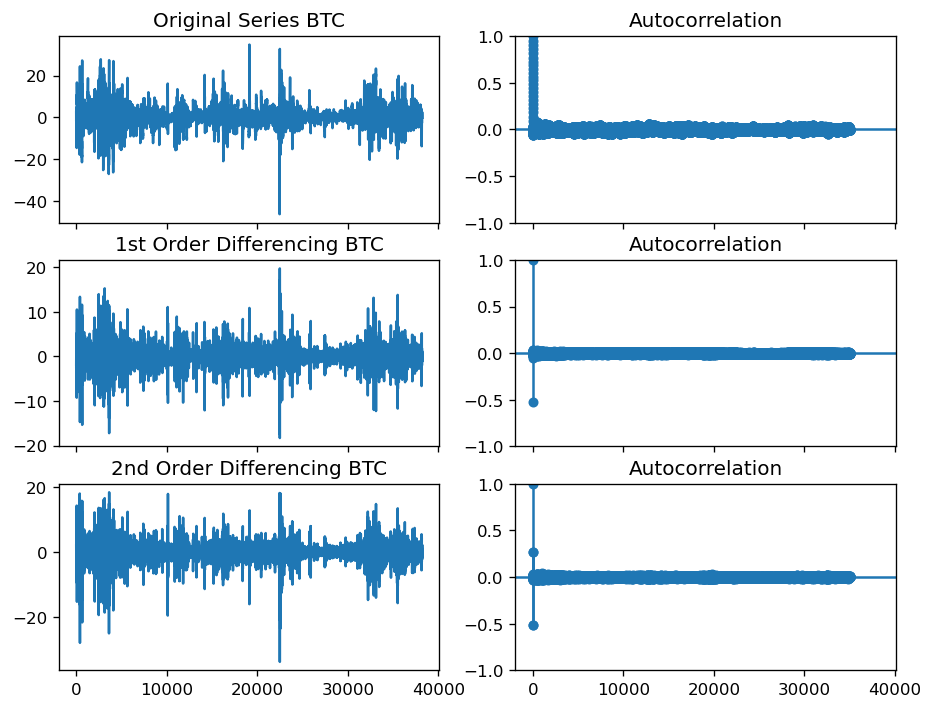

In [71]:
# We will plot the first and second differencing of BTC percent changes

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(y_BTC); axes[0, 0].set_title('Original Series '+coins[0])
plot_acf(y_BTC, lags=35000, ax=axes[0, 1])
    
# 1st Differencing
axes[1, 0].plot(y_BTC.diff()); axes[1, 0].set_title('1st Order Differencing '+coins[0])
plot_acf(y_BTC.diff().dropna(),lags=35000, ax=axes[1, 1])
    
# 2nd Differencing
axes[2, 0].plot(y_BTC.diff().diff()); axes[2, 0].set_title('2nd Order Differencing '+coins[0])
plot_acf(y_BTC.diff().diff().dropna(),lags=35000, ax=axes[2, 1])

plt.show()

From the graphs, it seems as if the d=1 makes the data stationary. If d=2, then it might be over-differenced.

### Partial Autocorrelation plot to determine p

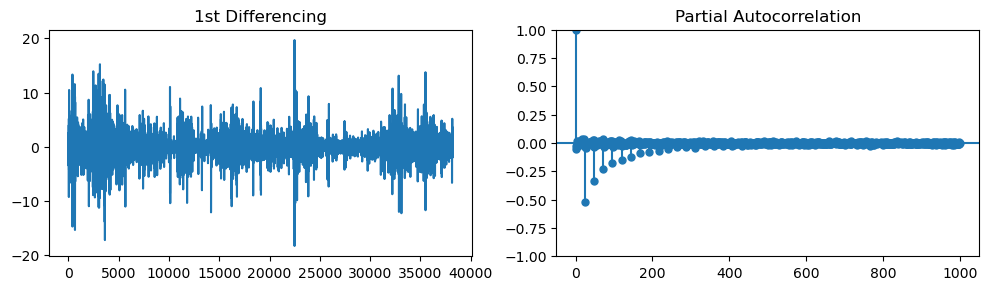

In [72]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':100})

fig, axes = plt.subplots(1, 2, sharex=False) # Note, I had to set sharex to false to get the full 19000 x-axis length
axes[0].plot(y_BTC.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,0.2)) # Note, I had to set the y-lim very low to see the points jutting from the blue region
plot_pacf(y_BTC.diff().dropna(), lags=1000,ax=axes[1])
plt.show()

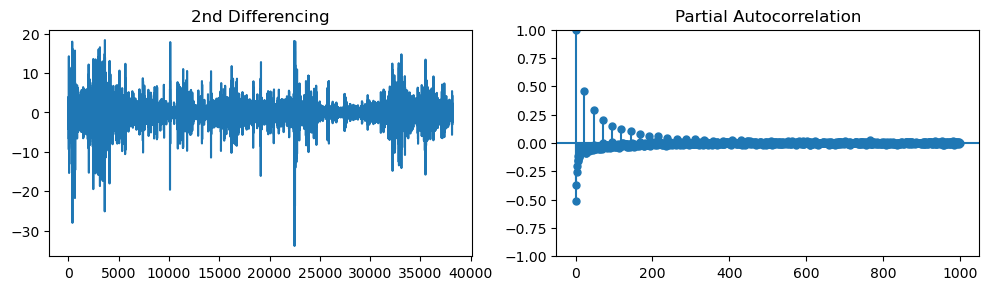

In [73]:
# PACF plot of 2nd differenced series
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':100})

fig, axes = plt.subplots(1, 2, sharex=False) # Note, I had to set sharex to false to get the full 900 x-axis length
axes[0].plot(y_BTC.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,0.2)) # Note, I had to set the y-lim very low to see the points jutting from the blue region
plot_pacf(y_BTC.diff().diff().dropna(), lags=1000,ax=axes[1])
plt.show()

We observe that the PACF lag 2 plot has most of the points above the significant line, so we will go with p=2. 

### The Moving Average, q

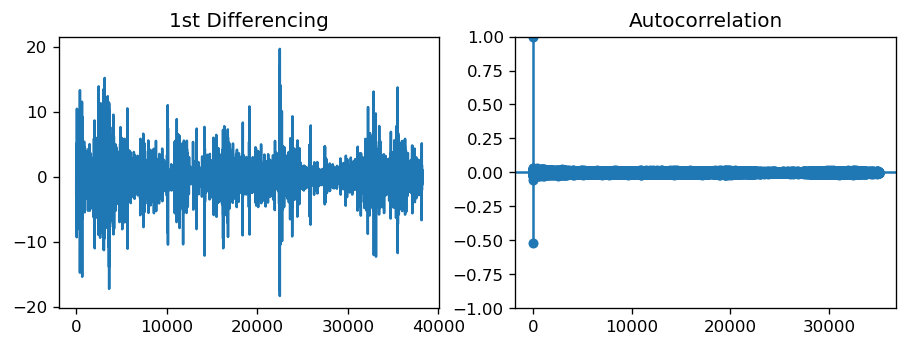

In [74]:
# Looking at the first autocorrelation

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_BTC.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(y_BTC.diff().dropna(), lags=35000, ax=axes[1])

plt.show()

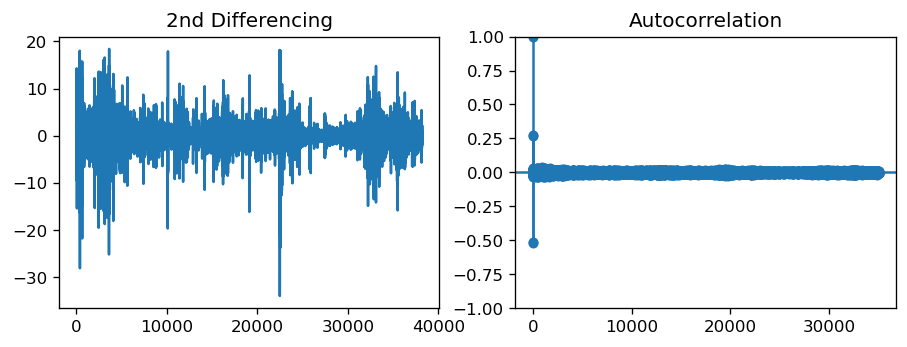

In [75]:
# Looking at the second autocorrelation

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_BTC.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(y_BTC.diff().diff().dropna(), lags=35000, ax=axes[1])

plt.show()

We will choose q=1, as though there are several lags above the significance level, it is the best of them.

### Seasonal Decomposition

Our data has negative values, so Multiplicative Decomposition is not appropriate

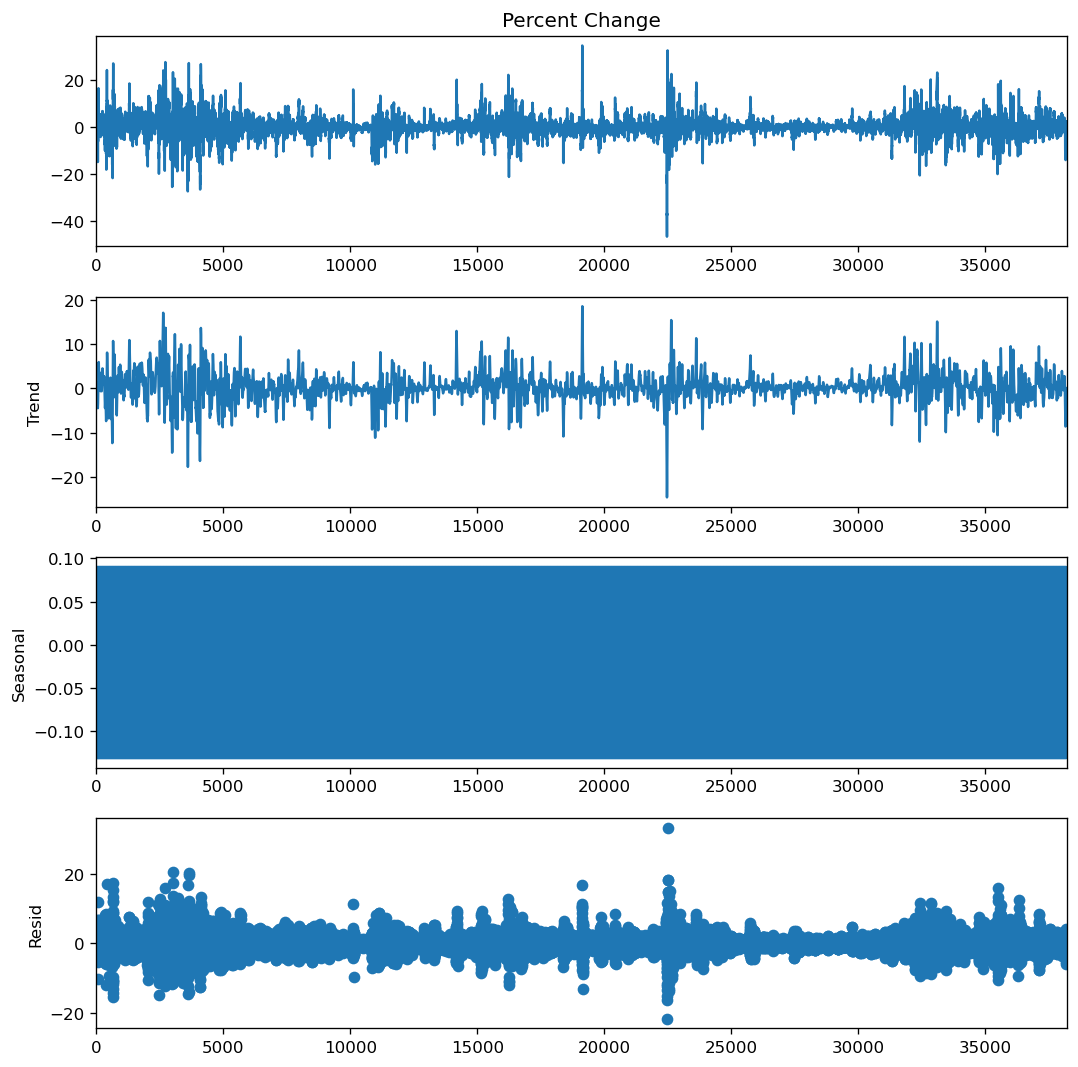

In [76]:
## from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Additive Decomposition
additive_decomposition = seasonal_decompose(y_BTC, model='additive', period=30)

additive_decomposition.plot()
plt.tight_layout(rect=[0, 2, 1, 5])

plt.show()

We are now ready to run Auto-SARIMAX to find the best parameters

## Auto-SARIMAX

### Data Preparation

In [87]:
# Getting our Data
X=pca_BTC
y=y_BTC

# Splitting into training and test sets
tss = TimeSeriesSplit()
for train_index, test_index in tss.split(X,y):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

### Auto-SARIMAX

In [88]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(y_train.to_numpy(), exogenous=X_train.to_numpy(), m=2, seasonal=True, suppress_warnings = True,  step_wise=True, trace=True)           
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=-20226.468, Time=378.45 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=-17082.311, Time=57.75 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=-20207.807, Time=340.69 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=-20183.606, Time=371.08 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=-17083.861, Time=217.93 sec
 ARIMA(1,1,1)(0,0,1)[2] intercept   : AIC=-20186.632, Time=372.42 sec
 ARIMA(1,1,1)(1,0,0)[2] intercept   : AIC=-20165.291, Time=355.63 sec
 ARIMA(1,1,1)(2,0,1)[2] intercept   : AIC=-20187.614, Time=420.26 sec
 ARIMA(1,1,1)(1,0,2)[2] intercept   : AIC=-20200.877, Time=448.63 sec
 ARIMA(1,1,1)(0,0,0)[2] intercept   : AIC=-19210.333, Time=606.68 sec
 ARIMA(1,1,1)(0,0,2)[2] intercept   : AIC=-20142.103, Time=191.41 sec
 ARIMA(1,1,1)(2,0,0)[2] intercept   : AIC=-20156.099, Time=122.22 sec
 ARIMA(1,1,1)(2,0,2)[2] intercept   : AIC=-20600.419, Time=141.54 sec
 ARIMA(0,1,1)(2,0,2)[2] intercept   : AIC=-20646

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                31835
Model:             SARIMAX(1, 1, 0)x(2, 0, [1, 2], 2)   Log Likelihood               10362.240
Date:                                Tue, 05 Oct 2021   AIC                         -20672.481
Time:                                        13:11:33   BIC                         -20454.905
Sample:                                             0   HQIC                        -20602.866
                                              - 31835                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.5274      0.129     27.317      0.000       3.274       3.781
x2            -0.2175      0.011    -19.138      0.000      -0.240      -0.195
x3            -0.0594      0.007     -8.154      0.000      -0.074      -0.045
x4            -0.0724      0.007    -10.964      0.000      -0.085      -0.059
x5            -0.1347      0.014     -9.383      0.000      -0.163      -0.107
x6            -0.0372      0.007     -5.277      0.000      -0.051      -0.023
x7             0.5903      0.011     54.175      0.000       0.569       0.612
x8             0.6797      0.004    152.706      0.000       0.671       0.688
x9             0.2020      0.002    106.359      0.000       0.198       0.206
x10            0.7338      0.003    238.287      0.000       0.728       0.740
x11           -0.0895      0.007    -12.017      0.000      -0.104      -0.075
x12            1.0473      0.009    110.320      0.000       1.029       1.066
x13            0.4150      0.006     69.763      0.000       0.403       0.427
x14           -0.1191      0.004    -32.001      0.000      -0.126      -0.112
x15           -0.5335      0.006    -88.977      0.000      -0.545      -0.522
x16           -0.3807      0.015    -24.727      0.000      -0.411      -0.351
x17            1.2021      0.003    425.768      0.000       1.197       1.208
x18           -1.4588      0.004   -404.362      0.000      -1.466      -1.452
x19           -3.3316      0.004   -935.692      0.000      -3.339      -3.325
x20           -0.7046      0.002   -446.653      0.000      -0.708      -0.702
ar.L1          0.2014      0.005     37.749      0.000       0.191       0.212
ar.S.L2       -0.1457      0.043     -3.421      0.001      -0.229      -0.062
ar.S.L4        0.3375      0.015     23.128      0.000       0.309       0.366
ma.S.L2       -0.1737      0.043     -4.072      0.000      -0.257      -0.090
ma.S.L4       -0.3648      0.020    -18.102      0.000      -0.404      -0.325
sigma2         0.0306      0.000    158.689      0.000       0.030       0.031
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              4196.61
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.21
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Best model from SARIMAX:  ARIMA(1,1,0)(2,0,2)[2]  

However, empirically, we find that the best model is ARIMA(0,0,0)(2,0,2)[2]  

### Trained SARIMAX with Auto-SARIMAX findings

In [103]:
model = SARIMAX(endog=y_train.to_numpy(), exog=X_train.to_numpy().astype(float), 
                order=(0, 0, 0),seasonal_order=(2, 0, 2, 2))
model = model.fit(disp=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:                            y   No. Observations:                31835
Model:             SARIMAX(2, 0, [1, 2], 2)   Log Likelihood                -661.438
Date:                      Tue, 05 Oct 2021   AIC                           1372.876
Time:                              14:34:24   BIC                           1582.084
Sample:                                   0   HQIC                          1439.814
                                    - 31835                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0265      0.001    -21.157      0.000      -0.029      -0.024
x2            -0.5662      0.001   -646.496      0.000      -0.568      -0.564
x3            -0.2998      0.002   -188.048      0.000      -0.303      -0.297
x4            -0.3155      0.001   -211.093      0.000      -0.318      -0.313
x5             0.2991      0.002    158.902      0.000       0.295       0.303
x6             0.1238      0.002     54.664      0.000       0.119       0.128
x7             0.2290      0.002     96.450      0.000       0.224       0.234
x8             0.5146      0.002    253.583      0.000       0.511       0.519
x9             0.1766      0.001    126.759      0.000       0.174       0.179
x10            0.6713      0.002    310.050      0.000       0.667       0.676
x11           -0.0428      0.003    -13.722      0.000      -0.049      -0.037
x12            0.7231      0.005    159.544      0.000       0.714       0.732
x13            0.3158      0.003     99.971      0.000       0.310       0.322
x14           -0.1007      0.002    -43.361      0.000      -0.105      -0.096
x15           -0.3331      0.003   -117.370      0.000      -0.339      -0.328
x16            0.0842      0.006     14.686      0.000       0.073       0.095
x17            1.2457      0.002    507.633      0.000       1.241       1.250
x18           -1.5303      0.003   -543.665      0.000      -1.536      -1.525
x19           -3.2228      0.003  -1075.266      0.000      -3.229      -3.217
x20           -0.6887      0.002   -330.561      0.000      -0.693      -0.685
ar.S.L2        0.2658      0.041      6.511      0.000       0.186       0.346
ar.S.L4        0.1626      0.030      5.434      0.000       0.104       0.221
ma.S.L2        0.2437      0.041      5.989      0.000       0.164       0.323
ma.S.L4        0.1350      0.013     10.314      0.000       0.109       0.161
sigma2         0.0610      0.000    128.093      0.000       0.060       0.062
===================================================================================
Ljung-Box (L1) (Q):                8000.07   Jarque-Bera (JB):               110.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.12
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Diagnostics

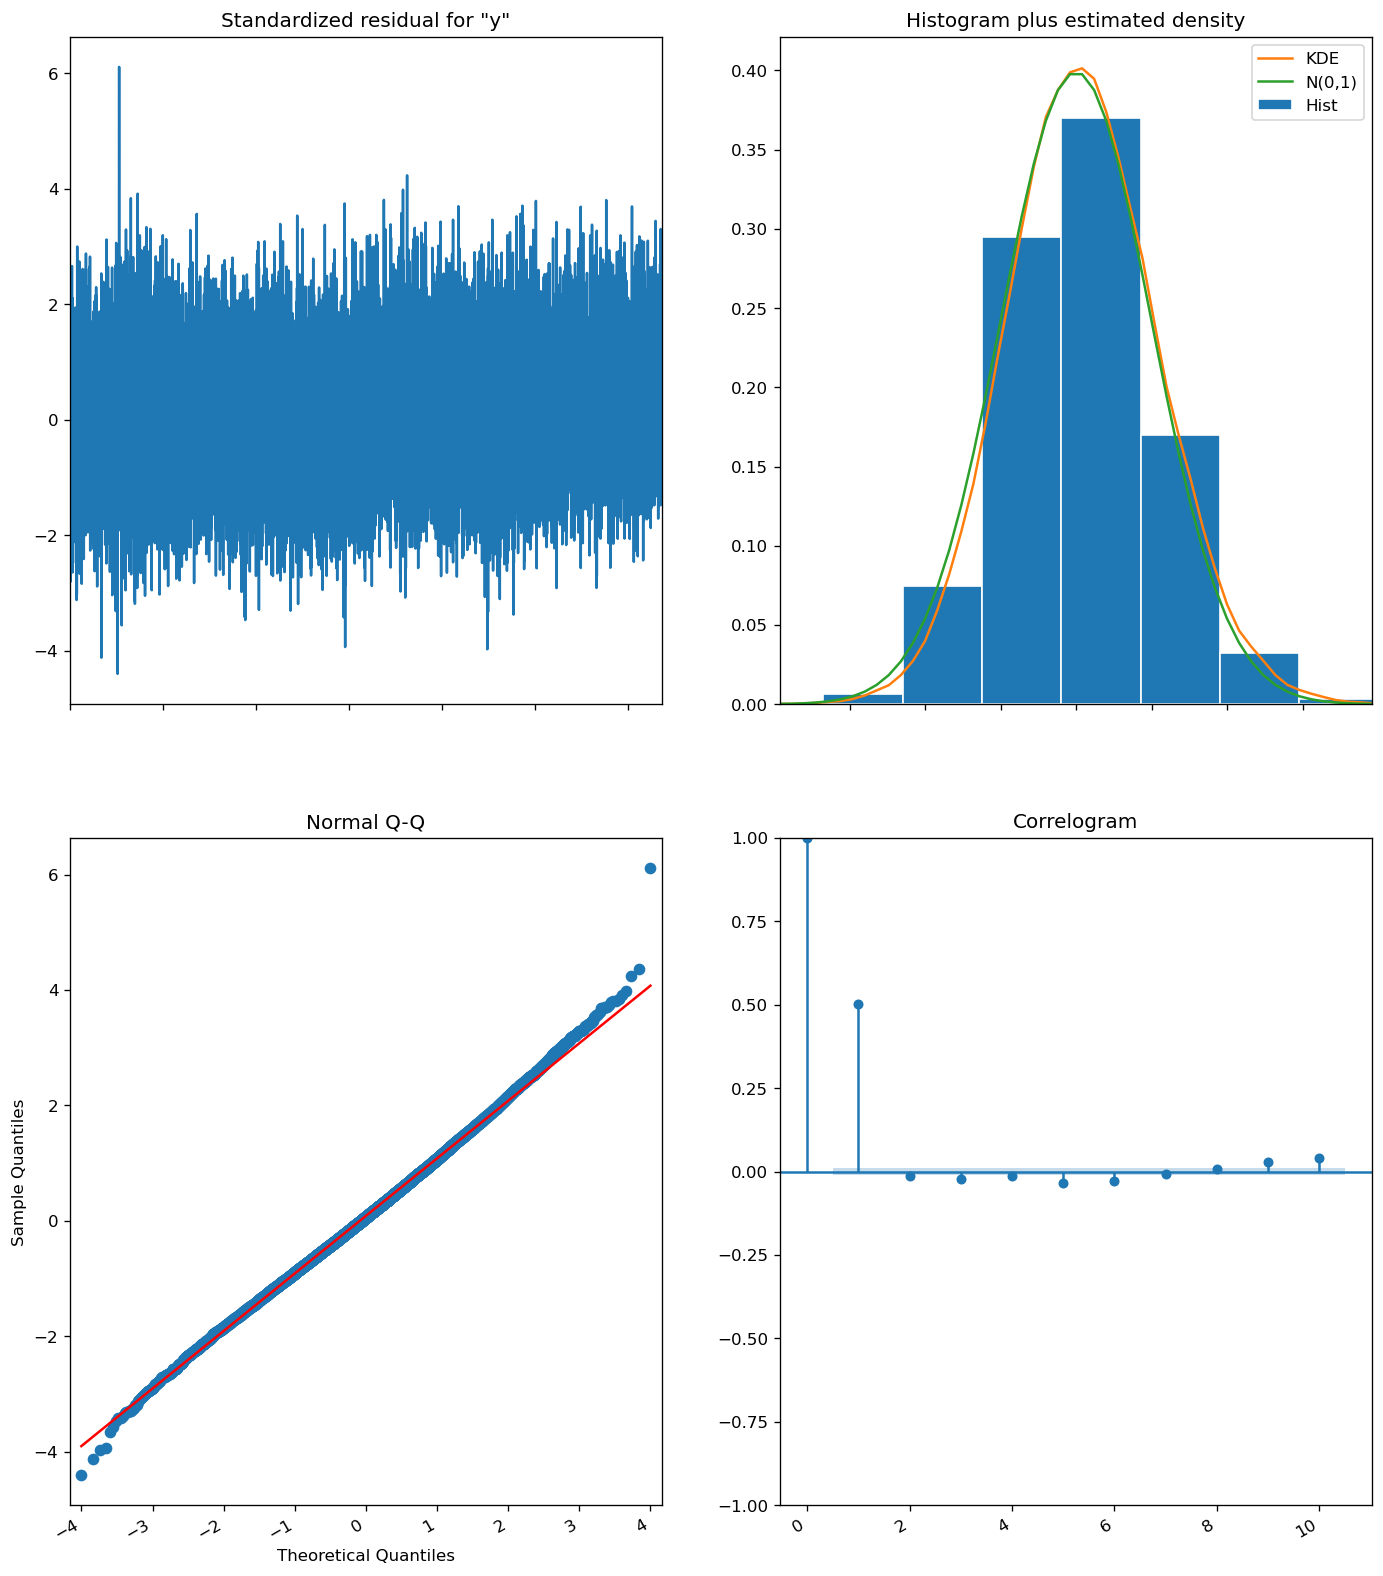

In [104]:
model.plot_diagnostics(figsize=(14,18))
plt.gcf().autofmt_xdate()
plt.show()

### Out-Of-Sample Forecasting

In [105]:
result = model.predict(start=len(X)-len(X_test), end=len(X)-1, exog=X_test.to_numpy().astype(float))

<AxesSubplot:>

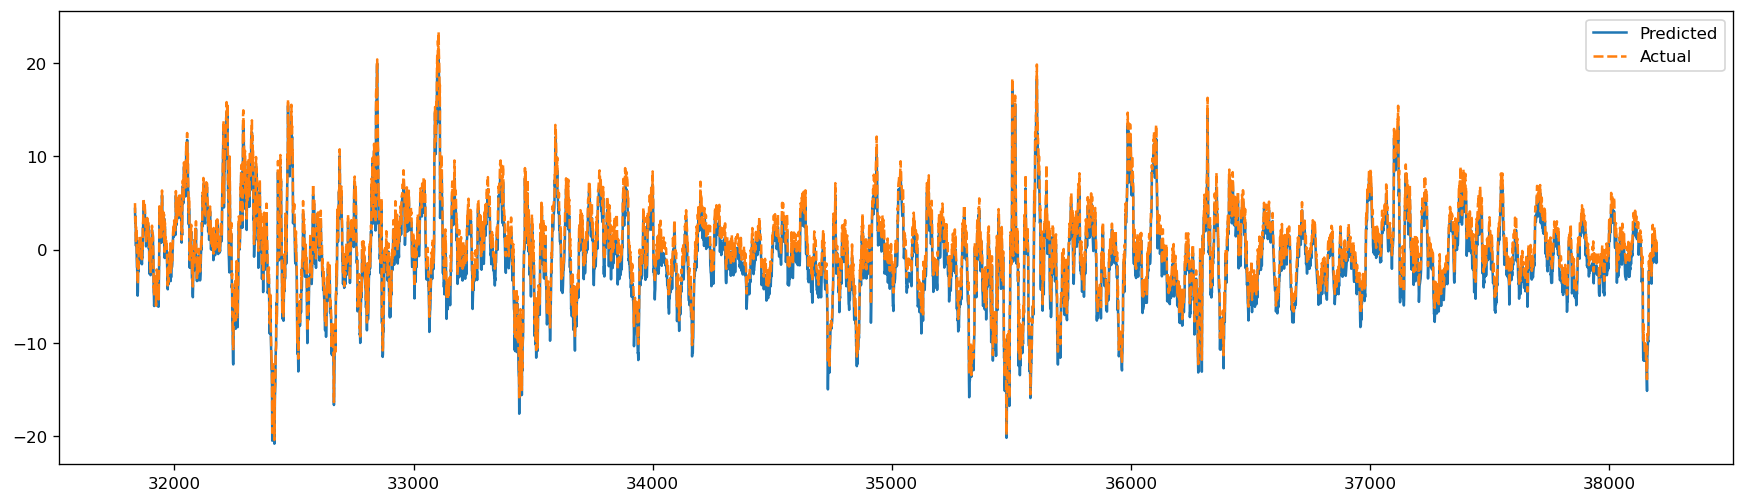

In [106]:
plt.figure(figsize=(18,5))
sns.lineplot(data=pd.DataFrame({'Predicted':result,'Actual':y_test}))

### One-Step-Ahead Forecasting

In [107]:
start_index = len(X)
end_index = len(X)
forecast = model.forecast(end_index, exog=X)
one_step_pred=forecast[-1]
print(one_step_pred)

-1.2448039701838123


# SARIMAX Modeling for ETH

## Manually setting up a model

### Parameters of the ARIMA model

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

### Differencing to Determine d

To begin, we need to determine whether or not to difference the data to make it more stationary. This will give us our parameter '"d".

We will use the Augmented Dickey Fuller Test to see if d should be anything other than 1.

In [108]:
for i in range(len(dfs)):
    result = adfuller(dfs[i])
    print('ADF Statistic for '+coins[i]+ ' is '+str(result[0]))
    print('p-value:for '+coins[i]+' is ' +str(result[1]))
    print('\n')

ADF Statistic for BTC is -20.83113366597517
p-value:for BTC is 0.0


ADF Statistic for ETH is -20.290583463541505
p-value:for ETH is 0.0


ADF Statistic for ADA is -12.961496647902889
p-value:for ADA is 3.2181989447146342e-24




From our results we can see the because the p-value is greater than the ADF Statistic for all three coins.

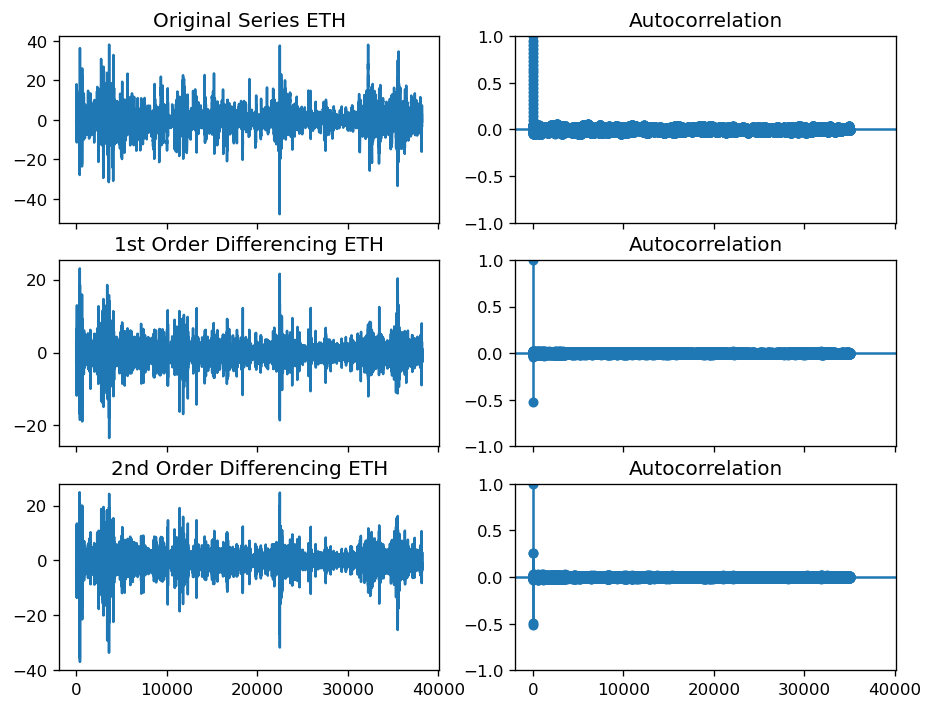

In [110]:
# We will plot the first and second differencing of BTC

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(y_ETH); axes[0, 0].set_title('Original Series '+coins[1])
plot_acf(y_ETH, lags=35000, ax=axes[0, 1])
    
# 1st Differencing
axes[1, 0].plot(y_ETH.diff()); axes[1, 0].set_title('1st Order Differencing '+coins[1])
plot_acf(y_ETH.diff().dropna(),lags=35000, ax=axes[1, 1])
    
# 2nd Differencing
axes[2, 0].plot(y_ETH.diff().diff()); axes[2, 0].set_title('2nd Order Differencing '+coins[1])
plot_acf(y_ETH.diff().diff().dropna(),lags=35000, ax=axes[2, 1])

plt.show()

From the graphs, it seems as if the d=1 makes the data stationary. If d=2, then it might be over-differenced.

### Partial Autocorrelation plot to determine p

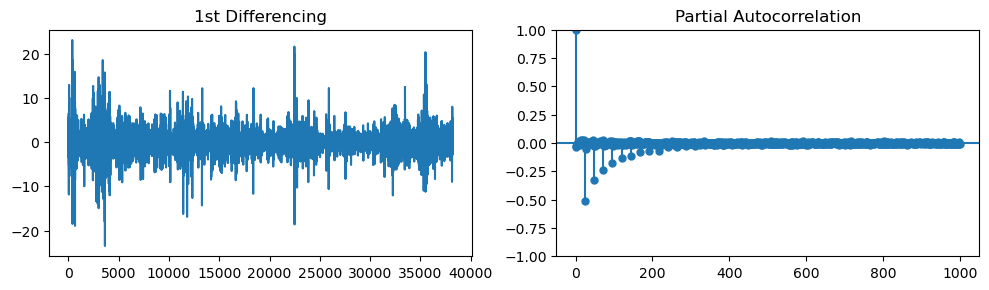

In [111]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':100})

fig, axes = plt.subplots(1, 2, sharex=False) # Note, I had to set sharex to false to get the full 19000 x-axis length
axes[0].plot(y_ETH.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,0.2)) # Note, I had to set the y-lim very low to see the points jutting from the blue region
plot_pacf(y_ETH.diff().dropna(), lags=1000,ax=axes[1])
plt.show()

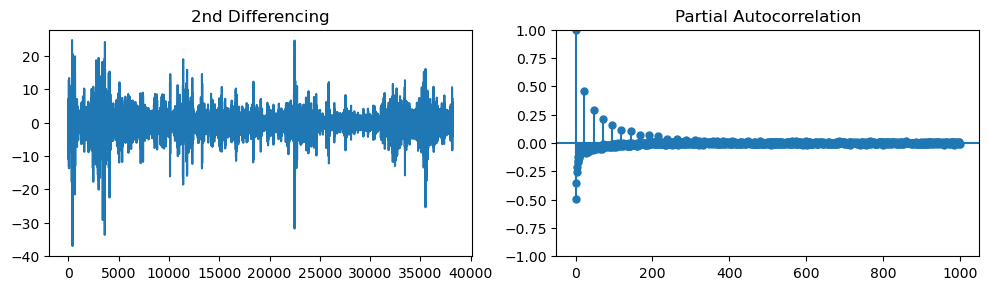

In [112]:
# PACF plot of 2nd differenced series
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':100})

fig, axes = plt.subplots(1, 2, sharex=False) # Note, I had to set sharex to false to get the full 900 x-axis length
axes[0].plot(y_ETH.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,0.2)) # Note, I had to set the y-lim very low to see the points jutting from the blue region
plot_pacf(y_ETH.diff().diff().dropna(), lags=1000,ax=axes[1])
plt.show()

We observe that the PACF lag 2 plot has most of the points above the significant line, so we will go with p=2. 

### The Moving Average, q

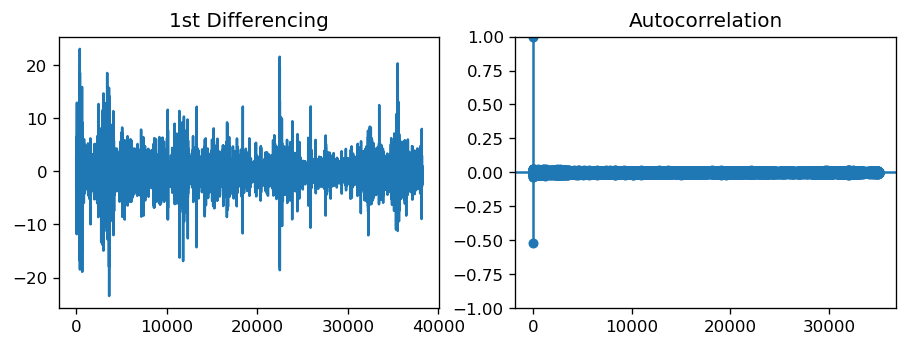

In [113]:
# Looking at the first autocorrelation

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_ETH.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(y_ETH.diff().dropna(), lags=35000, ax=axes[1])

plt.show()

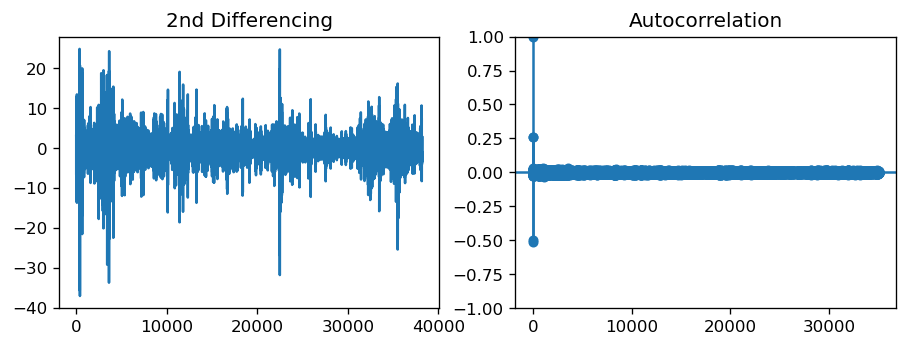

In [114]:
# Looking at the second autocorrelation

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_ETH.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(y_ETH.diff().diff().dropna(), lags=35000, ax=axes[1])

plt.show()

We will choose q=1, as though there are several lags above the significance level, it is the best of them.

### Seasonal Decomposition

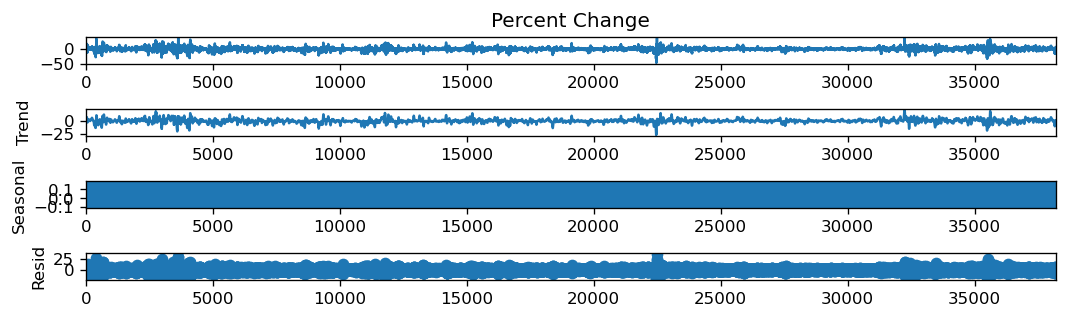

In [115]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
additive_decomposition = seasonal_decompose(y_ETH, model='additive', period=30)

# Plot

additive_decomposition.plot()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

We are now ready to run Auto-SARIMAX to find the best parameters

## Auto-SARIMAX

### Data Preparation

In [116]:
# Getting our Data
X=pca_ETH
y=y_ETH

# Splitting into training and test sets
tss = TimeSeriesSplit()
for train_index, test_index in tss.split(X,y):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

### Auto-SARIMAX

In [ ]:
# from pmdarima.arima import auto_arima

# auto_model = auto_arima(y_train.to_numpy(), exogenous=X_train.to_numpy(), m=2, seasonal=True, suppress_warnings = True,  step_wise=True, trace=True)           
# auto_model.summary()

Best model:  ARIMA(1,1,1)(0,0,0)[2]  

### Trained SARIMAX with Auto-SARIMAX findings

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(endog=y_train.to_numpy(), exog=X_train.to_numpy().astype(float), 
                order=(1, 1, 1),seasonal_order=(0, 0, 0, 2))
model = model.fit(disp=False)
model.summary()

### Out-Of-Sample Forecasting

In [ ]:
result = model.predict(start=len(X)-len(X_test), end=len(X)-1, exog=X_test.to_numpy().astype(float))

In [ ]:
plt.figure(figsize=(18,5))
sns.lineplot(data=pd.DataFrame({'Predicted':result,'Actual':y_test.to_numpy()}))

### One-Step-Ahead Forecasting

In [ ]:
start_index = len(X)
end_index = len(X)
forecast = model.forecast(end_index, exog=X)
one_step_pred=forecast[-1]
print(one_step_pred)

# SARIMAX Modeling for ADA

## Manually setting up a model

### Parameters of the ARIMA model

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

### Differencing to Determine d

To begin, we need to determine whether or not to difference the data to make it more stationary. This will give us our parameter '"d".

We will use the Augmented Dickey Fuller Test to see if d should be anything other than 1.

In [ ]:
for i in range(len(dfs)):
    result = adfuller(dfs[i]['Close'])
    print('ADF Statistic for '+coins[i]+ ' is '+str(result[0]))
    print('p-value:for '+coins[i]+' is ' +str(result[1]))
    print('\n')

From our results we can see the because the p-value is greater than the ADF Statistic for all three coins.

In [ ]:
# We will plot the first and second differencing of BTC

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(y_ADA, lags=35000, ax=axes[0, 1])
    
# 1st Differencing
axes[1, 0].plot(y_ADA.diff()); axes[1, 0].set_title('1st Order Differencing '+coins[0])
plot_acf(y_ADA.diff().dropna(),lags=35000, ax=axes[1, 1])
    
# 2nd Differencing
axes[2, 0].plot(y_ADA.diff().diff()); axes[2, 0].set_title('2nd Order Differencing '+coins[0])
plot_acf(y_ADA.diff().diff().dropna(),lags=35000, ax=axes[2, 1])

plt.show()

From the graphs, it seems as if the d=1 makes the data stationary. If d=2, then it might be over-differenced.

### Partial Autocorrelation plot to determine p

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':100})

fig, axes = plt.subplots(1, 2, sharex=False) # Note, I had to set sharex to false to get the full 19000 x-axis length
axes[0].plot(y_ADA.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,0.2)) # Note, I had to set the y-lim very low to see the points jutting from the blue region
plot_pacf(y_ADA.diff().dropna(), lags=1000,ax=axes[1])
plt.show()

In [ ]:
# PACF plot of 2nd differenced series
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':100})

fig, axes = plt.subplots(1, 2, sharex=False) # Note, I had to set sharex to false to get the full 900 x-axis length
axes[0].plot(y_ADA.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,0.2)) # Note, I had to set the y-lim very low to see the points jutting from the blue region
plot_pacf(y_ADA.diff().diff().dropna(), lags=1000,ax=axes[1])
plt.show()

We observe that the PACF lag 2 plot has most of the points above the significant line, so we will go with p=2. 

### The Moving Average, q

In [ ]:
# Looking at the first autocorrelation

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_ADA.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(y_ADA.diff().dropna(), lags=35000, ax=axes[1])

plt.show()

In [ ]:
# Looking at the second autocorrelation

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_ADA.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(y_ADA.diff().diff().dropna(), lags=35000, ax=axes[1])

plt.show()

We will choose q=1, as though there are several lags above the significance level, it is the best of them.

### Seasonal Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
additive_decomposition = seasonal_decompose(y_ADA, model='additive', period=30)

# Plot
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

We are now ready to run Auto-SARIMAX to find the best parameters

## Auto-SARIMAX

### Data Preparation

In [ ]:
# Getting our Data
X=pca_ADA
y=y_ADA

# Splitting into training and test sets
tss = TimeSeriesSplit()
for train_index, test_index in tss.split(X,y):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

### Auto-SARIMAX

In [ ]:
# from pmdarima.arima import auto_arima

# auto_model = auto_arima(y_train.to_numpy(), exogenous=X_train.to_numpy(), m=2, seasonal=True, suppress_warnings = True,  step_wise=True, trace=True)           
# auto_model.summary()

Best model:  ARIMA(1,1,1)(0,0,0)[2]  

### Trained SARIMAX with Auto-SARIMAX findings

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(endog=y_train.to_numpy(), exog=X_train.to_numpy().astype(float), 
                order=(1, 1, 1),seasonal_order=(0, 0, 0, 2))
model = model.fit(disp=False)
model.summary()

### Out-Of-Sample Forecasting

In [ ]:
result = model.predict(start=len(X)-len(X_test), end=len(X)-1, exog=X_test.to_numpy().astype(float))

In [ ]:
plt.figure(figsize=(18,5))
sns.lineplot(data=pd.DataFrame({'Predicted':result,'Actual':y_test.to_numpy()}))

### One-Step-Ahead Forecasting

In [ ]:
start_index = len(X)
end_index = len(X)
forecast = model.forecast(end_index, exog=X)
one_step_pred=forecast[-1]
print(one_step_pred)